## Importing libraries and loading data

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

from teachopencadd.utils import seed_everything

seed_everything() # to get deterministic outputs

In [3]:
CURRENT_DIRECTORY = Path.cwd()
DATA_DIRECTORY = CURRENT_DIRECTORY.parent.parent.parent/'data'/'fda_approved_datasets'
IMAGE_DIRECTORY = CURRENT_DIRECTORY.parent.parent.parent/'imgs'/'fda_clusters'

In [4]:
fda_drugs_df = pd.read_csv(DATA_DIRECTORY/'fda_approved_drugs.csv')
print(f'Dataframe shape: ', fda_drugs_df.shape)
fda_drugs_df.head()

Dataframe shape:  (1895, 14)


,name,chembl_id,clean_smiles,first_approval_year,indication_class,molecule_type,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,GUANIDINE HYDROCHLORIDE,CHEMBL1200728,N=C(N)N,1939,NaN,Small molecule,False,True,False,False,False,True,False,False
1,ACETOHYDROXAMIC ACID,CHEMBL734,CC(=O)NO,1983,Enzyme Inhibitor (urease),Small molecule,False,True,False,False,False,True,False,False
2,HYDROXYUREA,CHEMBL467,NC(=O)NO,1967,Antineoplastic,Small molecule,False,True,False,False,False,True,False,False
3,CYSTEAMINE,CHEMBL602,NCCS,1994,CYSTEAMINE HYDROCHLORIDE,Small molecule,False,True,False,False,False,True,False,True
4,DIMETHYL SULFOXIDE,CHEMBL504,C[S+](C)[O-],1978,Anti-Inflammatory (topical),Small molecule,False,True,False,False,False,False,True,False


In [5]:
# Create a rdkit.Chem.Mol object from SMILES and store in list
compounds = []

for _, chembl_id, smiles, name in fda_drugs_df[['chembl_id','clean_smiles', 'name']].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id, name))

print(f'Number of compounds inserted into list: {len(compounds)}')
compounds[0:5]

Number of compounds inserted into list: 1895


[(<rdkit.Chem.rdchem.Mol at 0x7f1cc1785640>,
  'CHEMBL1200728',
  'GUANIDINE HYDROCHLORIDE'),
 (<rdkit.Chem.rdchem.Mol at 0x7f1cc1785760>,
  'CHEMBL734',
  'ACETOHYDROXAMIC ACID'),
 (<rdkit.Chem.rdchem.Mol at 0x7f1cc1785b20>, 'CHEMBL467', 'HYDROXYUREA'),
 (<rdkit.Chem.rdchem.Mol at 0x7f1cc17856a0>, 'CHEMBL602', 'CYSTEAMINE'),
 (<rdkit.Chem.rdchem.Mol at 0x7f1cc1785700>,
  'CHEMBL504',
  'DIMETHYL SULFOXIDE')]

## Generating fingerprints, calculating tanimoto and distance matrix

### 1) Generating fingerprints

In [6]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, chembl_id, name in compounds]

print(f'Number of compounds converted: {len(fingerprints)}.\
    Fingerprint length per compounds: {len(fingerprints[0])}')

Number of compounds converted: 1895.    Fingerprint length per compounds: 2048


### 2) Tanimoto similarity and Distance matrix

In [7]:
def tanimoto_distance_matrix(fp_list:list) -> list:
    """
    Recieves a fingerprint list and calculate the distance matrix (list of lists). 
    This function is used inside the cluster algorithm.
    """
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

To assess if the number of elements (n) inside the dissimilarity matrix is correct we can check if `n = (n* (n-1)) / 2`, i.e the same number of elements in the upper triangle matrix of the same size. 

In [8]:
# Checking if the dissimilarity matrix has the same number of elements as 
# triangular matrix via n*(n-2)/2

n = len(fingerprints)

elem_triangular_matr = (n*(n-1)) / 2

print(
    f"Elements in the triangular matrix {elem_triangular_matr:.0f} == ",
    f"tanimoto_distance_matrix(fingerprints): {len(tanimoto_distance_matrix(fingerprints))}"
)

Elements in the triangular matrix 1794565 ==  tanimoto_distance_matrix(fingerprints): 1794565


## Clustering: centroids and exclusion spheres

In [9]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """
    Clusterization based on fingerprints
    Parameters:
    fingerprints (list)
    cutoff: threshold for the clustering
    """
    
    distance_matrix = tanimoto_distance_matrix(fingerprints)

    # Caclulate Tanimoto distance matrix
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In order to pick a reasonable cutoff we will have to take a closer look on the choice of the cutoff. To do this, we manually test a range of threshold from 0 - 1 in 0.1 increments.

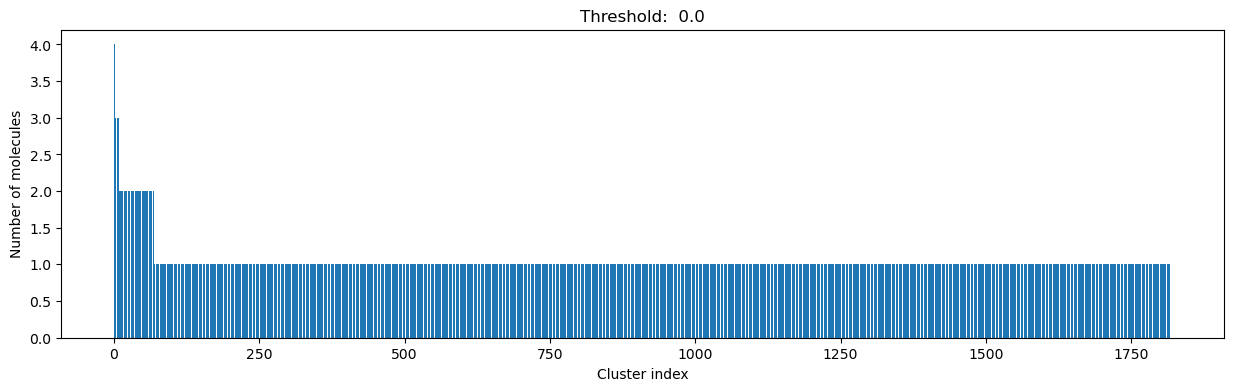

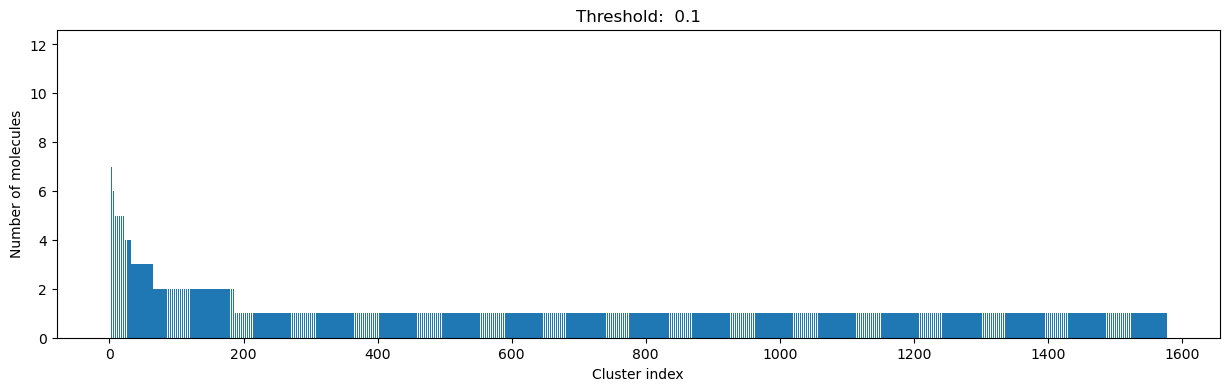

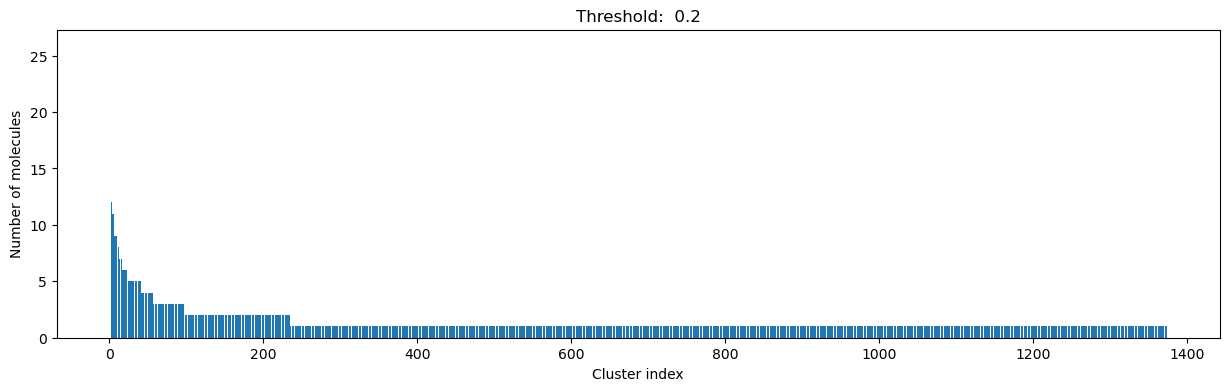

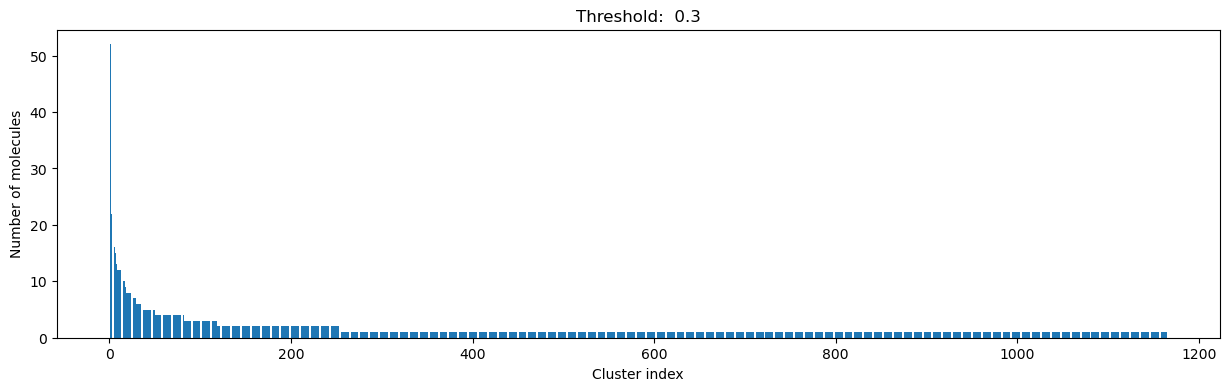

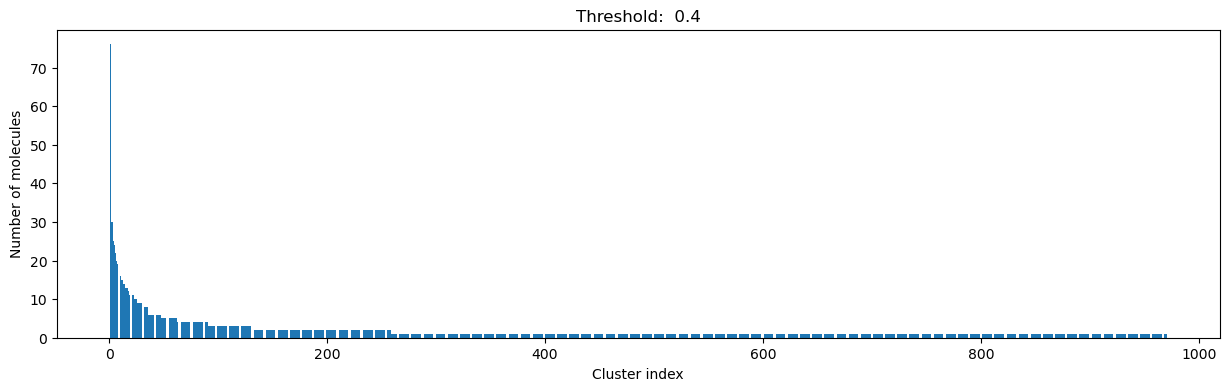

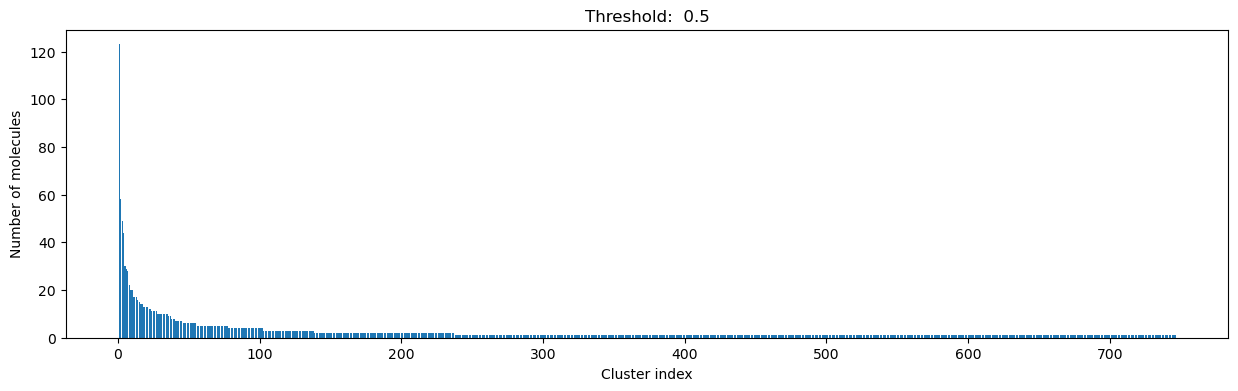

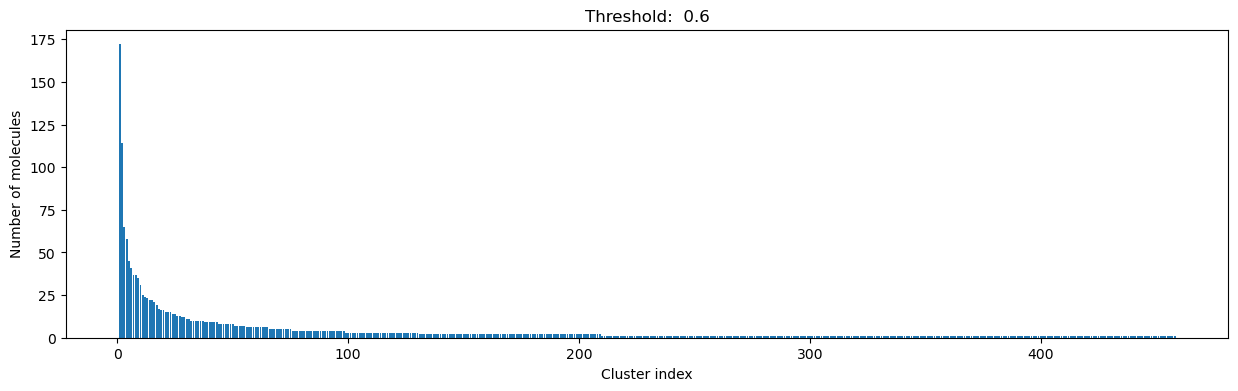

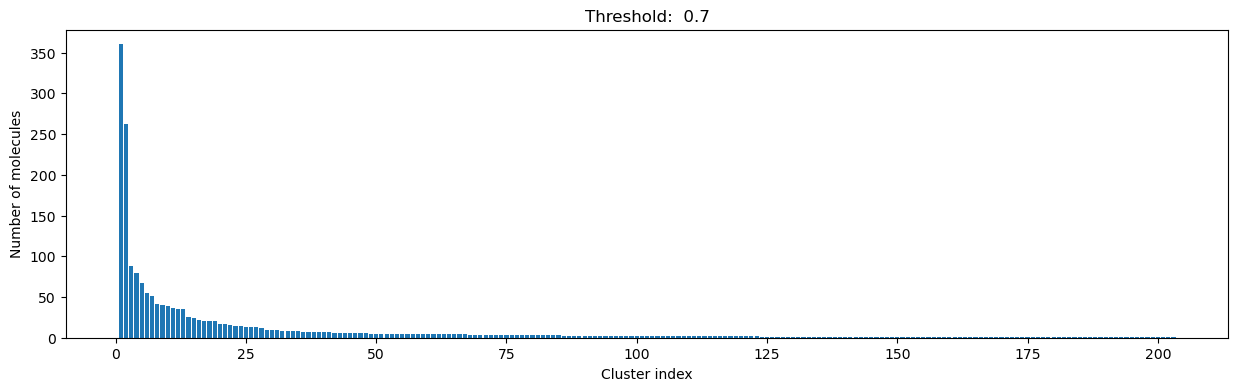

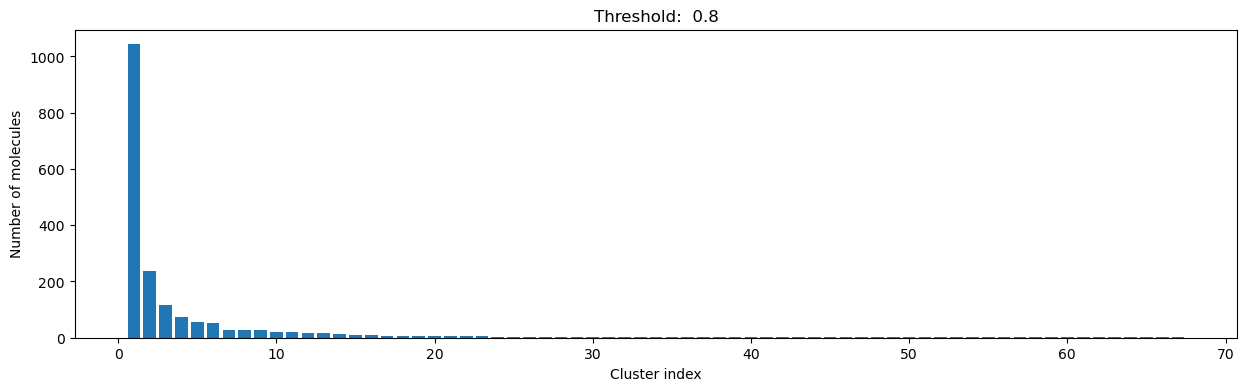

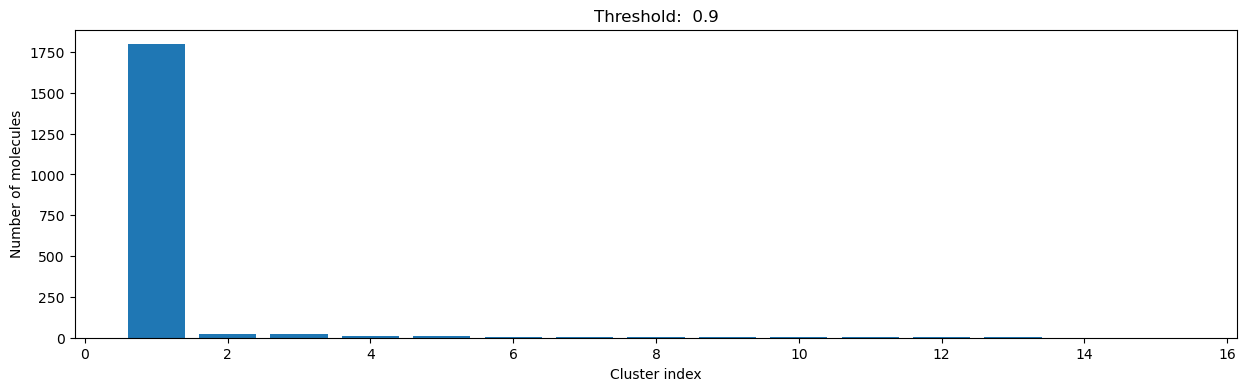

In [10]:
cutoffs = np.arange(0.0, 1.0, 0.1)

for cutoff in cutoffs:
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(9,4))
    ax.set_title(f"Threshold: {cutoff: 3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

Maybe the best option here is 0.6, visually but that is debatable.

Text(0.5, 1.0, 'Threshold of dissimilarity: 0.4')

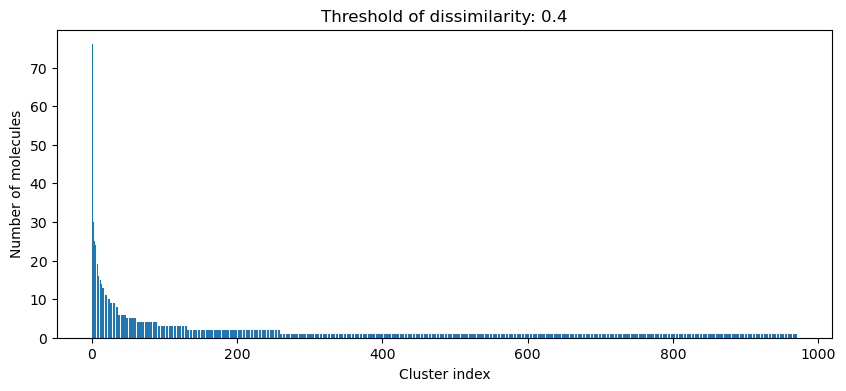

In [11]:
cutoff=0.4
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Number of molecules')
ax.bar(range(1, len(clusters) +1), [len(c) for c in clusters])
ax.set_title(f"Threshold of dissimilarity: {cutoff}")

In [12]:
print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} structures at a distance cut-off: {cutoff}"
)
print(f"Number of molecules in the first 20 clusters: {sum([len(clusters[x]) for x in range(0,20)])} that is {sum([len(clusters[x]) for x in range(0,20)])/len(compounds) * 100:.2f}%")
print(f"Number of molecules in the largest cluster: {len(clusters[0])}")
print(f"Similarity between two random points in same cluster({DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][2]]):.2f})")
print(f"Similarity between two random points in different cluster({DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][2]]):.2f})")

Number of clusters: 970 from 1895 structures at a distance cut-off: 0.4
Number of molecules in the first 20 clusters: 409 that is 21.58%
Number of molecules in the largest cluster: 76
Similarity between two random points in same cluster(0.63)
Similarity between two random points in different cluster(0.14)


## Visualization

### Examples of structures inside each cluster (First three clusters)

15 molecules from the first cluster:

There are 76 structures in the first cluster.


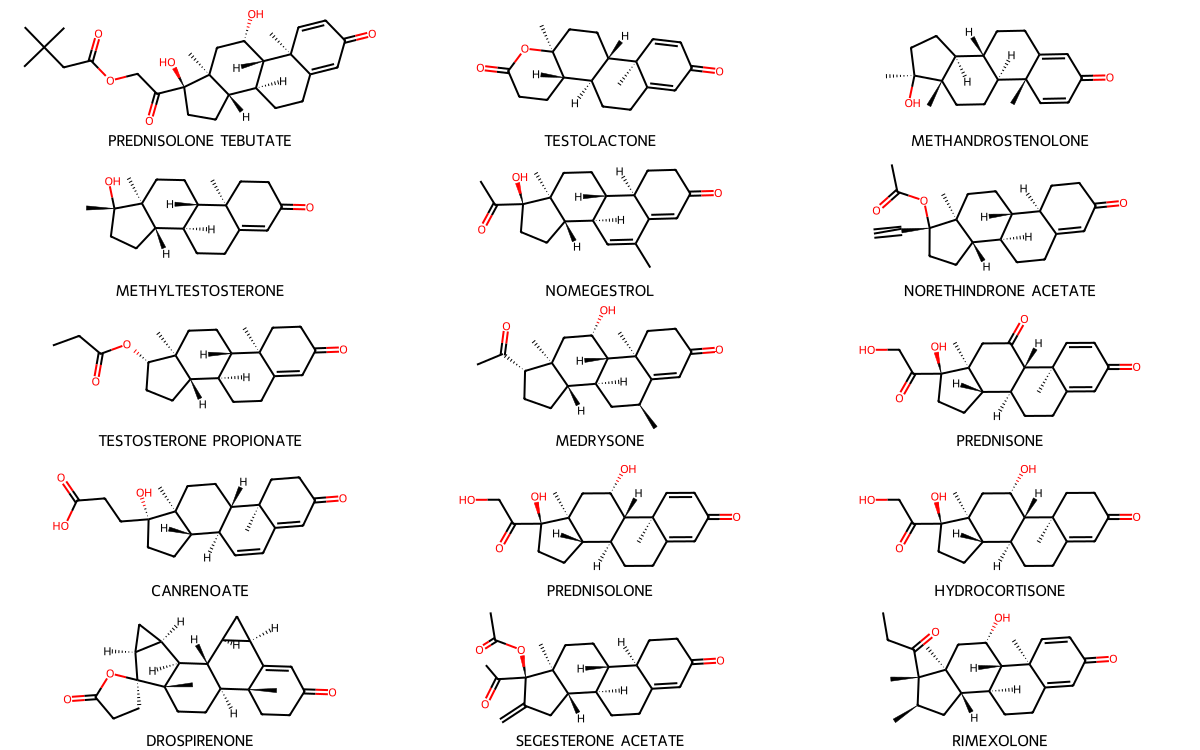

In [13]:
# 15 examples from largest clusters
print('15 molecules from the first cluster:\n')
print(f'There are {len(clusters[0])} structures in the first cluster.')
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:15]],
     legends=[compounds[i][2] for i in clusters[0][:15]],
     molsPerRow=3,
     subImgSize=(400,150)
)

The first 15 structures of the second largest cluster: 

There are 30 structures on the second largest cluster.


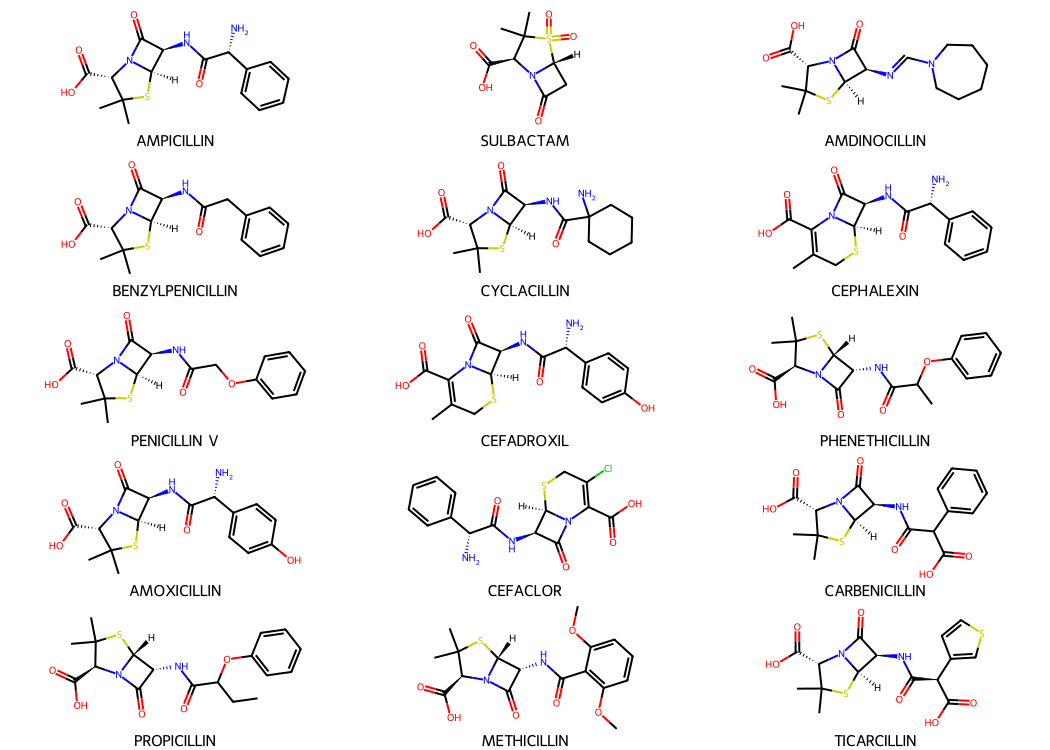

In [14]:
# 15 examples from the second largest cluster
print('The first 15 structures of the second largest cluster: \n')
print(f'There are {len(clusters[1])} structures on the second largest cluster.')
# Drawing
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[1][:15]],
    legends=[compounds[i][2] for i in clusters[1][:15]],
    molsPerRow=3,
    subImgSize=(350,150)

)

The first 15 structures of the third largest cluster: 

There are 30 structures on the third largest cluster.


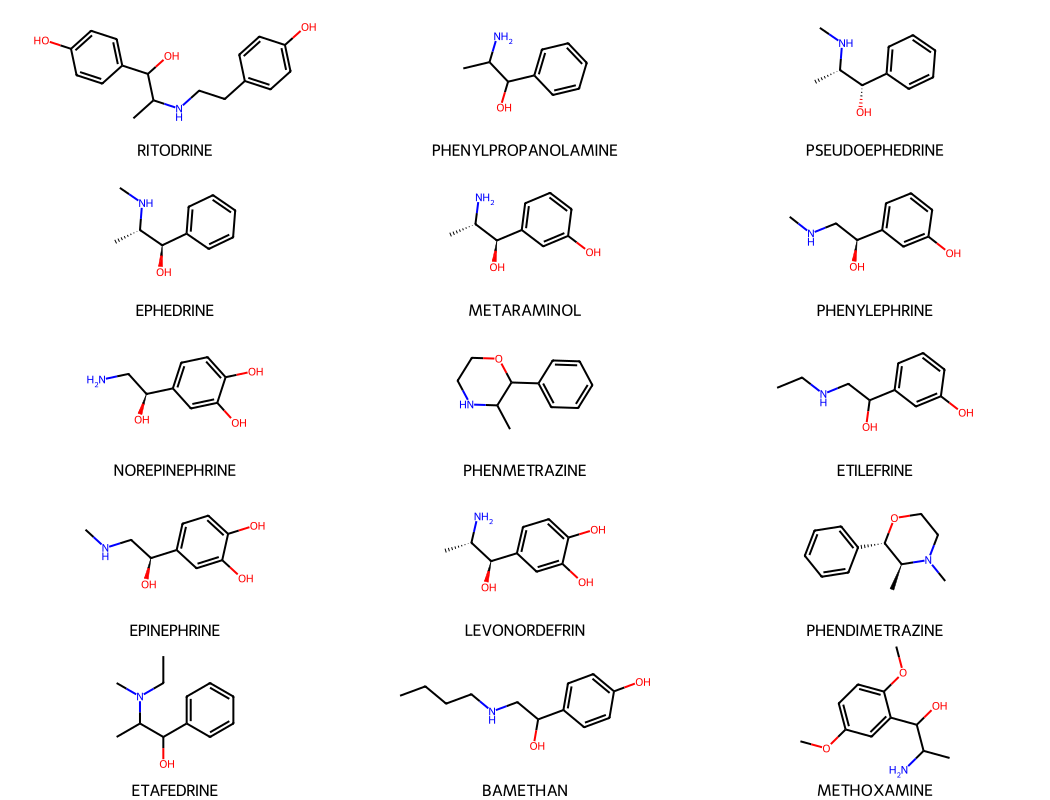

In [15]:
# 15 examples from the second largest cluster
print('The first 15 structures of the third largest cluster: \n')
print(f'There are {len(clusters[2])} structures on the third largest cluster.')
# Drawing
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[2][:15]],
    legends=[compounds[i][2] for i in clusters[2][:15]],
    molsPerRow=3,
    subImgSize=(350,160)
)

### Intracluster similarity

In [16]:
# Define the function to compute intra-tanimoto similarity
def intra_tanimoto(fps_clusters):
    """
    Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster
    """
    intra_similarity=[]
    for cluster in fps_clusters:
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    
    return intra_similarity

In [17]:
# Recompute fingerprints for 15 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:20]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

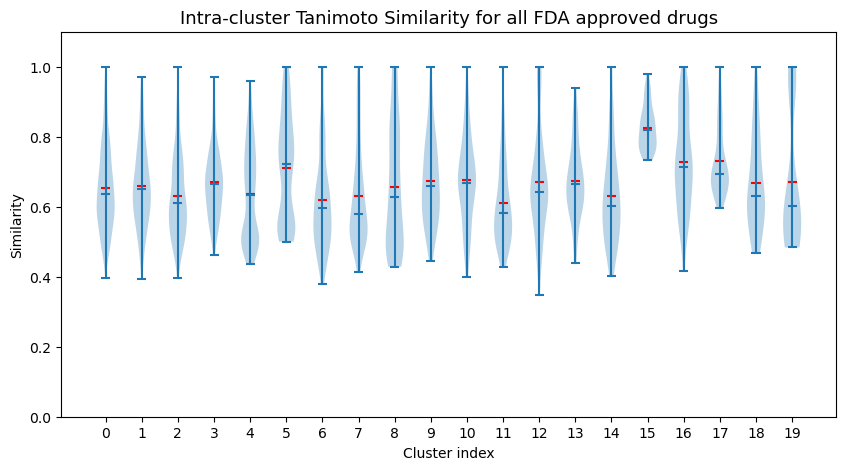

In [18]:
# Violin plots with intra-cluster similarity
fig, ax = plt.subplots(figsize=(10,5))
indices = list(range(20))
ax.set_xlabel('Cluster index')
ax.set_ylabel('Similarity')
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.0, 1.2, 0.2))
ax.set_ylim(0,1.1)
ax.set_title('Intra-cluster Tanimoto Similarity for all FDA approved drugs', fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=True)
r['cmeans'].set_color('red')

### Get cluster centroids

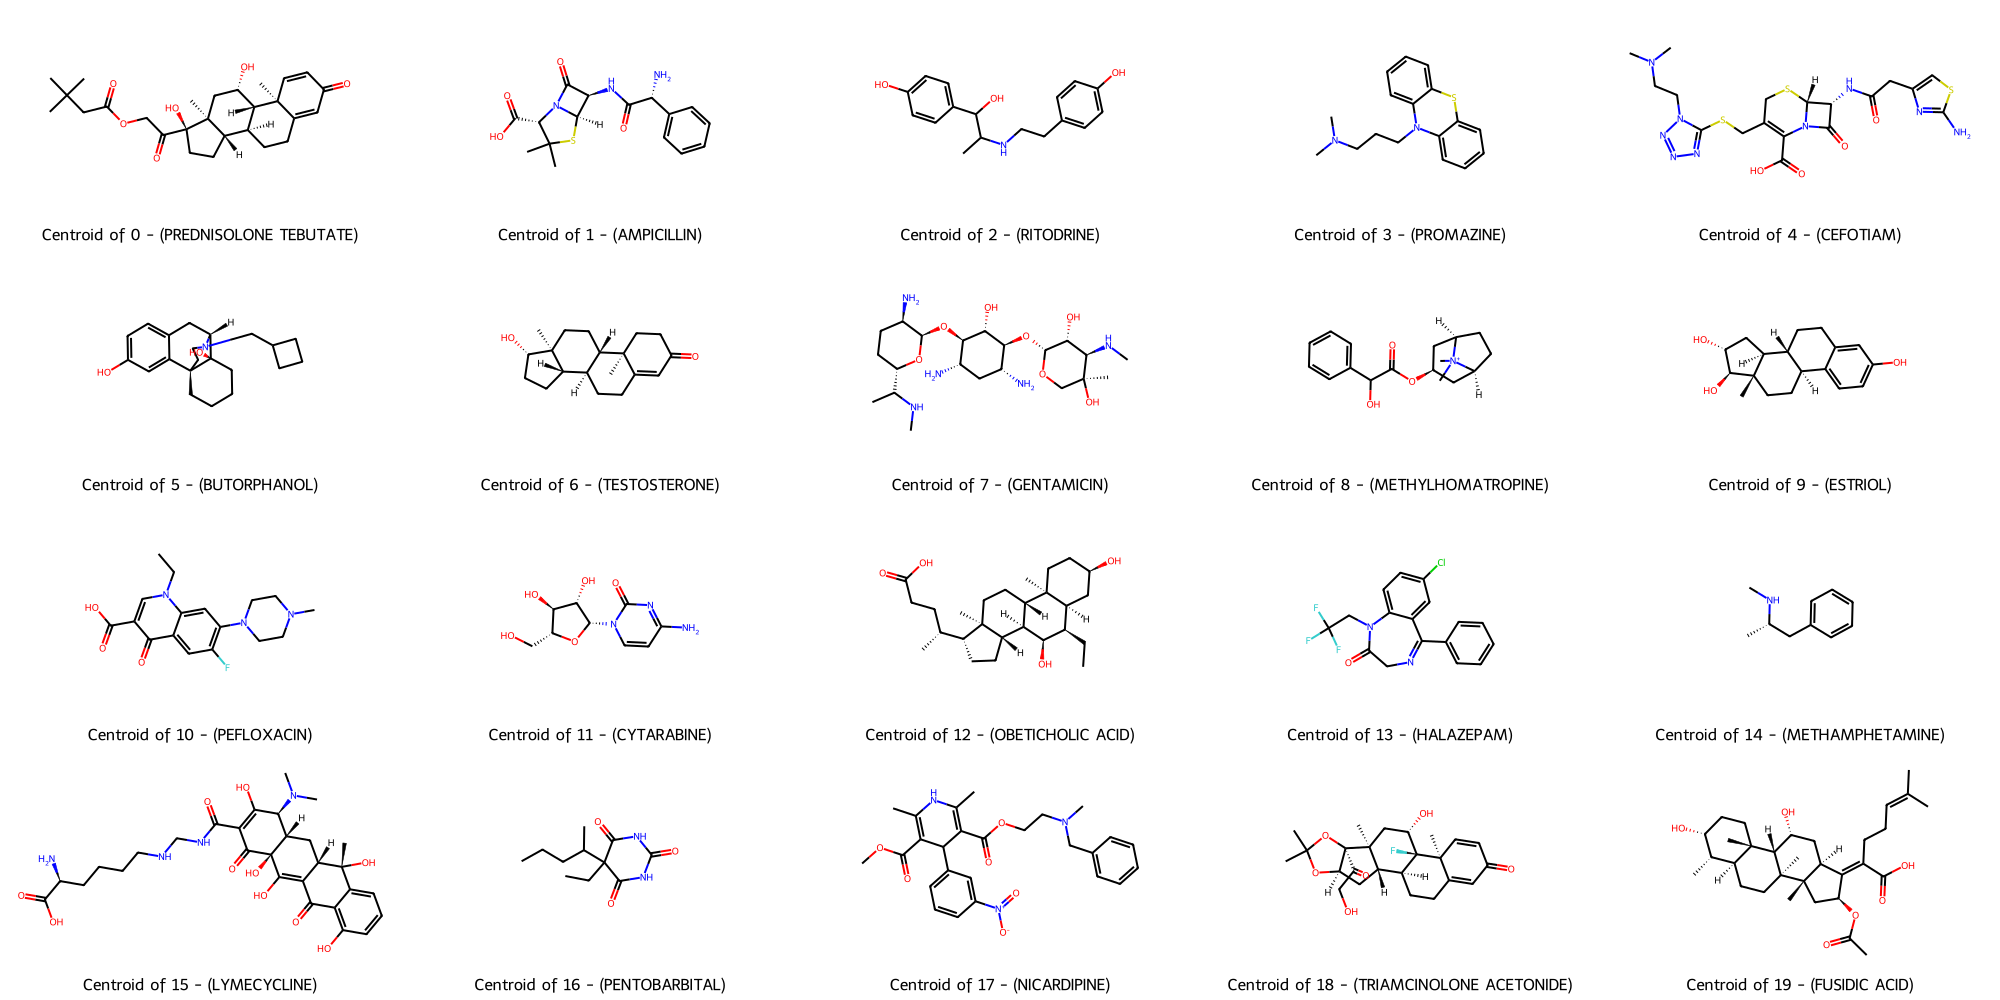

In [19]:
# First 20 clusters centroids
cluster_centers = [compounds[c[0]] for c in clusters[0:20]]
legends = []
for cluster_id, (mol, chembl_id, name) in enumerate(cluster_centers):
    legends.append(f'Centroid of {cluster_id} - ({name})')

centroids = Draw.MolsToGridImage(
    [mol for mol, chembl_id, name in cluster_centers],
    legends = legends,
    molsPerRow=5,
    subImgSize=(400,250),
    useSVG=False
)
centroids

## Investigation of interesting clusters

In [20]:
# seeing what is stored in clusters[0]
top_20_clusters = clusters[0:20]

cluster_info = []
for cluster_id in range(len(top_20_clusters)):
    for i in top_20_clusters[cluster_id]:
        cluster_info.append({'cluster': cluster_id, 'index': i, 'chembl_id': compounds[i][1]})

cluster_info = pd.DataFrame(cluster_info)

In [21]:
# merging flags info about oral
flag_columns = [
    'chembl_id', 
    'withdrawn_flag', 
    'therapeutic_flag', 
    'polymer_flag', 
    'inorganic_flag', 
    'natural_product_flag', 
    'oral', 
    'parenteral', 
    'topical'
]

cluster_info = cluster_info.merge(fda_drugs_df[flag_columns], how='left', on='chembl_id')
cluster_info.head()

,cluster,index,chembl_id,withdrawn_flag,therapeutic_flag,polymer_flag,inorganic_flag,natural_product_flag,oral,parenteral,topical
0,0,1474,CHEMBL1200909,False,True,False,False,True,False,True,False
1,0,653,CHEMBL1571,False,True,False,False,False,True,True,False
2,0,657,CHEMBL1418176,True,True,False,False,True,True,False,False
3,0,671,CHEMBL1395,False,True,False,False,True,True,False,True
4,0,843,CHEMBL2105722,False,True,False,False,True,True,False,False


In [22]:
oral_cluster = cluster_info[['cluster', 'withdrawn_flag', 'natural_product_flag', 'oral', 'parenteral', 'topical']].groupby(['cluster']).sum()
group_size = cluster_info[['cluster', 'withdrawn_flag', 'natural_product_flag', 'oral', 'parenteral', 'topical']].groupby(['cluster']).size()
group_size = group_size.to_frame('n')

# Final table
cluster_flags_table = oral_cluster.merge(group_size, on='cluster', how='left')
cluster_flags_table = cluster_flags_table[['n', 'oral', 'parenteral', 'topical', 'natural_product_flag', 'withdrawn_flag']]
cluster_flags_table['cluster'] = cluster_flags_table.index
cluster_flags_table

,n,oral,parenteral,topical,natural_product_flag,withdrawn_flag,cluster
cluster,,,,,,,
0,76,27,26,39,74,1,0
1,30,15,15,0,30,0,1
2,30,14,10,12,0,7,2
3,25,19,12,4,1,2,3
4,24,5,17,0,24,0,4
5,22,15,13,4,15,2,5
6,20,14,4,5,20,0,6
7,19,10,11,5,18,0,7
8,16,8,2,4,0,1,8


In [23]:
def get_percentage_column(df, flag_column, n_total):
    """
    Function to get the percentage of column relative to n_total in a wide format 
    """
    df[f'{flag_column}_perc'] = df[flag_column] / df[n_total] * 100
    
    return df

cluster_percentage_flags = cluster_flags_table.copy()
for column in cluster_percentage_flags.drop(['cluster', 'n'], axis=1):
    cluster_percentage_flags = get_percentage_column(df=cluster_percentage_flags,flag_column=column, n_total='n')

cluster_percentage_flags.head(3)

,n,oral,parenteral,topical,natural_product_flag,withdrawn_flag,cluster,oral_perc,parenteral_perc,topical_perc,natural_product_flag_perc,withdrawn_flag_perc
cluster,,,,,,,,,,,,
0,76,27,26,39,74,1,0,35.526316,34.210526,51.315789,97.368421,1.315789
1,30,15,15,0,30,0,1,50.000000,50.000000,0.000000,100.000000,0.000000
2,30,14,10,12,0,7,2,46.666667,33.333333,40.000000,0.000000,23.333333


/tmp/ipykernel_29089/466517045.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{int(x)}%' for x in ax.get_yticks()])  # Format y-axis tick labels as percentages


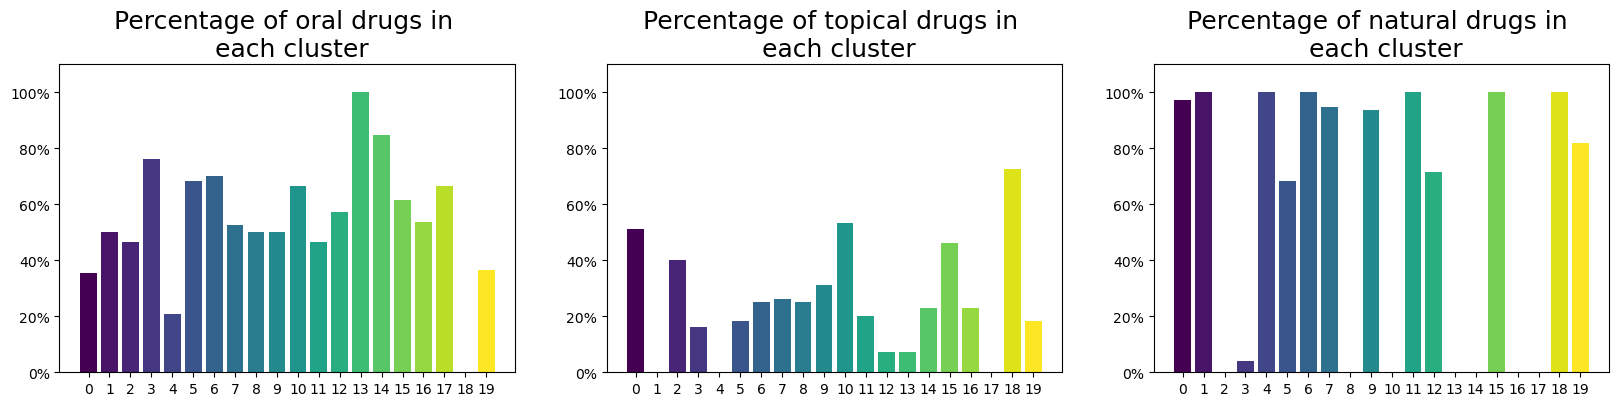

In [24]:
## go to dataviz

# Create subplots for each '_perc' column
columns_to_plot = ['oral_perc', 'topical_perc', 'natural_product_flag_perc']

cluster_percentage_flags.set_index('cluster')
# Define the number of rows and columns for the subplot grid
num_rows = 1
num_cols = 3
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_percentage_flags.index)))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 4))
fig.subplots_adjust(hspace=0.5, wspace=0.2)  # Adjust vertical spacing


for i, column in enumerate(columns_to_plot):
    row = i // num_cols  # Calculate the row index
    col = i % num_cols   # Calculate the column index

    # Plot the data in the current subplot
    ax = axes[col]
    for cluster, color in zip(cluster_percentage_flags.index, colors):
        ax.bar(cluster_percentage_flags.index, cluster_percentage_flags[column], color=colors)
        ax.set_title(f'Percentage of {column.split("_")[0]} drugs in \n each cluster', fontsize=18)
        ax.set_xlabel('',  fontsize=16)
        ax.set_ylim(0, 110)
        ax.set_yticklabels([f'{int(x)}%' for x in ax.get_yticks()])  # Format y-axis tick labels as percentages
        ax.set_xticks(cluster_percentage_flags.index)

# Show the subplots
plt.show()


There are 11 structures on the 18 cluster. and all of them are topical!


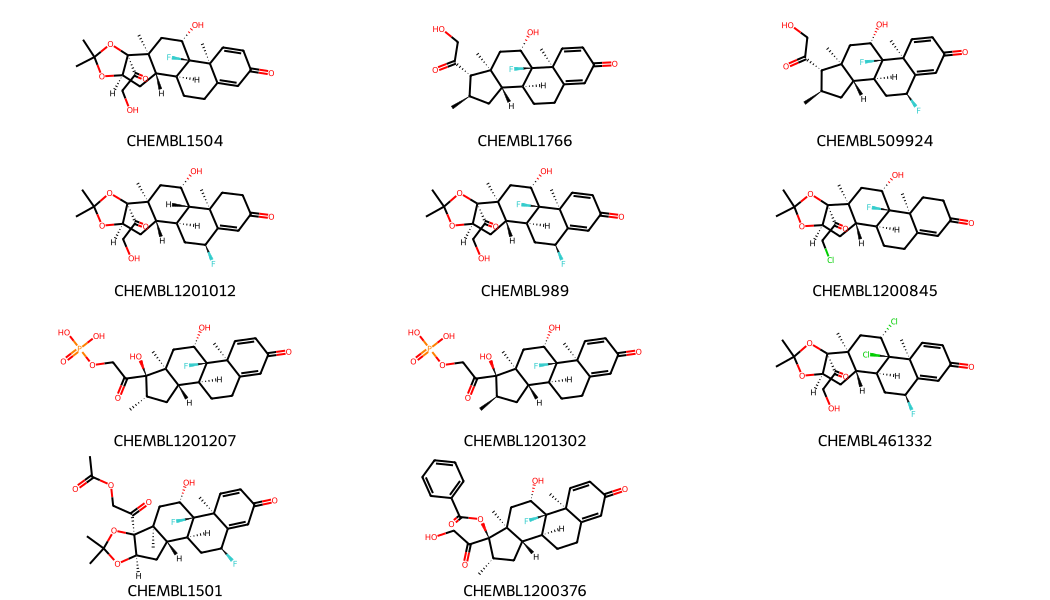

In [25]:
# Investigating cluster 18!
# 15 examples from the second largest cluster
print(f'There are {len(clusters[18])} structures on the 18 cluster. and all of them are topical!')
# Drawing
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[18][:]],
    legends=[compounds[i][1] for i in clusters[18][:]],
    molsPerRow=3,
    subImgSize=(350,150)

)

There are 24 structures on the 18 cluster a lot is not oral


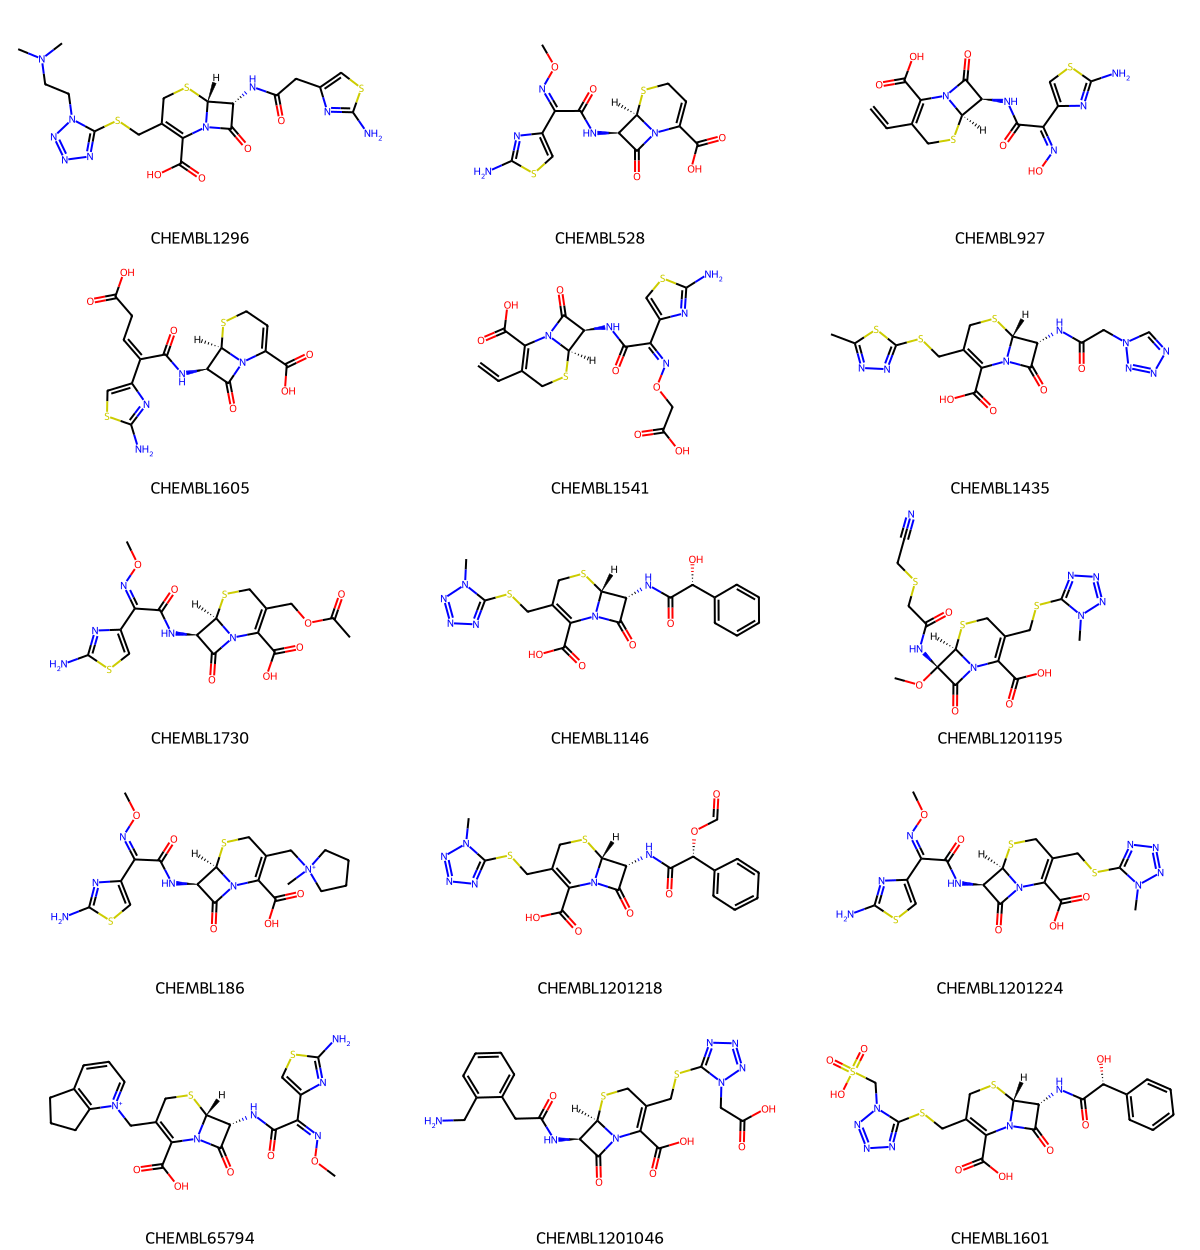

In [26]:
# Investigating cluster 5!
# 15 examples from the second largest cluster
print(f'There are {len(clusters[4])} structures on the 18 cluster a lot is not oral')
# Drawing
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[4][:15]],
    legends=[compounds[i][1] for i in clusters[4][:15]],
    molsPerRow=3,
    subImgSize=(400,250)

)

## Dimensionality reduction

We first need to table the data of each structure to each cluster. 

Then calculate some descriptors using rdkit, and finally do some dimension reduction.

In [40]:
table_info = []

for cluster_id, cluster in enumerate(clusters):
    for structure in cluster:
        table_info.append({'cluster_id': cluster_id, 'mol': compounds[structure][0], 'chembl_id': compounds[structure][1]})

table_info_df = pd.DataFrame(table_info)


,cluster_id,mol,chembl_id
0,0,<rdkit.Chem.rdchem.Mol object at 0x7f1cc16d8be0>,CHEMBL1200909
1,0,<rdkit.Chem.rdchem.Mol object at 0x7f1cc1738340>,CHEMBL1571
2,0,<rdkit.Chem.rdchem.Mol object at 0x7f1cc17384c0>,CHEMBL1418176
3,0,<rdkit.Chem.rdchem.Mol object at 0x7f1cc1738a00>,CHEMBL1395
4,0,<rdkit.Chem.rdchem.Mol object at 0x7f1cc173fb80>,CHEMBL2105722
...,...,...,...
1890,965,<rdkit.Chem.rdchem.Mol object at 0x7f1cc1785700>,CHEMBL504
1891,966,<rdkit.Chem.rdchem.Mol object at 0x7f1cc17856a0>,CHEMBL602
1892,967,<rdkit.Chem.rdchem.Mol object at 0x7f1cc1785b20>,CHEMBL467
1893,968,<rdkit.Chem.rdchem.Mol object at 0x7f1cc1785760>,CHEMBL734
